# Phase profile in directed Human Brain Connectome

In [1]:
import sys
import importlib

sys.path.append("../")

from src import utils
from src.utils import *

from src import operations
from src import graph_utils
from src import braingraph_utils


import h5py
import nibabel as nib
from scipy.io import loadmat

import scienceplots
plt.style.use(['science','ieee', 'no-latex'])

# for better visualisation of graphs. Comment out if not needed
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.figsize'] = [3, 2]

## Description

Phase profile in directed human brain connectome

GOAL: Analyse phase profile of of HCP task fMRI

In [2]:
import scipy

def p_value(null_distrib: np.ndarray, statistic: float, two_tail: bool = False):
    """
    Calculates the p-value for a given test statistic and null distribution.

    Parameters:
    -----------
    null_distrib : np.ndarray
        The null distribution to compare the statistic against.
    statistic : float 
        The test statistic value.
    two_tail : bool, optional
        Whether to calculate a two-tailed p-value, by default False.

    Returns:
    --------
    score : float
        The calculated p-value.
    """

    rc = null_distrib > statistic
    lc = null_distrib < statistic

    score_r = np.mean(rc)
    score_l = np.mean(lc)
    score = min(score_r, score_l)

    if two_tail:
        score *= 2
        score = min(score, 1)

    return score

## Table of Contents
- [Phase Profile in fMRI](#phase-profile)

In [3]:
resource_path = '../resources/'
data_path = '/Users/mikichan/Desktop/mywork/atlas_data/'

## Graph Phase profile - During task

### Loading Graph and Transform

In [4]:
package = utils.load(utils.op.join(resource_path, 'brain_directed_graph/bin_directed_connectome_ftract+structural-d50+metadata.pkl'))
A, roi_atlas, region_labels, regioncoords = package['struct'], package['atlas'], package['regionnames'], package['regioncoords']

nb_nodes = A.shape[0]

L, U, V, Uinv, _, _, _ = graph_utils.prep_transform(A, gso="laplacian")

Lu, Uu, Vu, Uinvu, _, _, _ = graph_utils.prep_transform(((A + A.T) > 0).astype(float), gso="laplacian")

### Preparing Motor/Rest fMRI

In [5]:
# LOAD DATA - MOTOR TASK
TR = 0.72
# HRF - pad is not added as the timepoints are already matched with the task paradigm
list_subjects = ['100307', '100408', '101107', '101309', '101915']

taskparadigms1 = []
taskparadigms2 = []

for subject in list_subjects:
    taskparadigms1.append(loadmat(op.join(data_path, f'HCP_sample/HCP_taskparadigm_labels/{subject}_Regressor_tfMRI_MOTOR_LR.mat'))['Regressor'][0])
    taskparadigms2.append(loadmat(op.join(data_path, f'HCP_sample/HCP_taskparadigm_labels/{subject}_Regressor_tfMRI_MOTOR_RL.mat'))['Regressor'][0])
taskparadigms1 = np.concatenate(taskparadigms1)
taskparadigms2 = np.concatenate(taskparadigms2)
ntimepoints = taskparadigms1.shape[-1]

print(f"Number of timepoints = {ntimepoints}")

# HCP task data - atlasing
motor1_roi_timecourses = []
motor2_roi_timecourses = []
atlas_data, affine = roi_atlas.get_fdata(), roi_atlas.affine
for subject in tqdm(list_subjects):
    subpath2volumes = f'HCP_sample/HCP_motor/volume/{subject}/'
    file_list1 =  os.listdir(op.join(data_path, subpath2volumes, 'tfMRI_MOTOR_LR/fMRIvols_GLMyes'))
    reorder_list1 = np.argsort([int(file[-8:-4]) for file in file_list1 if file.endswith('.nii') or file.endswith('.nii.gz')])
    file_list1 = np.array(file_list1)[reorder_list1]
    tmpvol = np.array([nib.load(op.join(data_path, subpath2volumes, f'tfMRI_MOTOR_LR/fMRIvols_GLMyes/{file}')).get_fdata() 
                            for file in file_list1])

    m, s = tmpvol[tmpvol!=0].mean(), tmpvol[tmpvol!=0].std()
    tmpvol[tmpvol!=0] = (tmpvol[tmpvol!=0] - m)/s

    tmp_roi_timecourses = np.zeros((nb_nodes, tmpvol.shape[0]))
    for k in range(1, nb_nodes + 1):
        tmp_roi_timecourses[k-1] = tmpvol[:, atlas_data == k].mean(axis=1)
    motor1_roi_timecourses.append(zscore(tmp_roi_timecourses, axis=1))

    file_list2 =  os.listdir(op.join(data_path, subpath2volumes, 'tfMRI_MOTOR_RL/fMRIvols_GLMyes'))
    reorder_list2 = np.argsort([int(file[-8:-4]) for file in file_list2 if file.endswith('.nii') or file.endswith('.nii.gz')])
    file_list2 = np.array(file_list2)[reorder_list2]

    tmpvol = np.array([nib.load(op.join(data_path, subpath2volumes, f'tfMRI_MOTOR_RL/fMRIvols_GLMyes/{file}')).get_fdata() 
                            for file in file_list2])
    
    m, s = tmpvol[tmpvol!=0].mean(), tmpvol[tmpvol!=0].std()
    tmpvol[tmpvol!=0] = (tmpvol[tmpvol!=0] - m)/s
    tmp_roi_timecourses = np.zeros((nb_nodes, tmpvol.shape[0]))
    for k in range(1, nb_nodes + 1):
        tmp_roi_timecourses[k-1] = tmpvol[:, atlas_data == k].mean(axis=1)
    motor2_roi_timecourses.append(zscore(tmp_roi_timecourses, axis=1))
    
motor1_roi_timecourses = np.concatenate(motor1_roi_timecourses, axis=1)
motor2_roi_timecourses = np.concatenate(motor2_roi_timecourses, axis=1)

Number of timepoints = 1420


100%|██████████| 5/5 [00:52<00:00, 10.46s/it]


### Population-wise

In [6]:
graph_fourier_timecourse1 = np.array([operations.GFT(motor1_roi_timecourses[:, t], U=U, Uinv=Uinv) for t in range(ntimepoints)])
graph_fourier_timecourse2 = np.array([operations.GFT(motor2_roi_timecourses[:, t], U=U, Uinv=Uinv) for t in range(ntimepoints)])

#### Motor left vs Motor right (lateralized phase check)

In [7]:
left_foot = motor1_roi_timecourses[:, np.where(taskparadigms1 == 1)[0]]
right_foot = motor1_roi_timecourses[:, np.where(taskparadigms1 == 2)[0]]

left_hand = motor1_roi_timecourses[:, np.where(taskparadigms1 == 3)[0]]
right_hand = motor1_roi_timecourses[:, np.where(taskparadigms1 == 4)[0]]

lfoot_gft = np.array([operations.GFT(left_foot[:, t], U=U, Uinv=Uinv) for t in range(left_foot.shape[1])])
rfoot_gft = np.array([operations.GFT(right_foot[:, t], U=U, Uinv=Uinv) for t in range(right_foot.shape[1])])

lhand_gft = np.array([operations.GFT(left_hand[:, t], U=U, Uinv=Uinv) for t in range(left_hand.shape[1])])
rhand_gft = np.array([operations.GFT(right_hand[:, t], U=U, Uinv=Uinv) for t in range(right_hand.shape[1])])

lfoot_gft_u = np.array([operations.GFT(left_foot[:, t], U=Uu, Uinv=Uinvu) for t in range(left_foot.shape[1])])
rfoot_gft_u = np.array([operations.GFT(right_foot[:, t], U=Uu, Uinv=Uinvu) for t in range(right_foot.shape[1])])

lhand_gft_u = np.array([operations.GFT(left_hand[:, t], U=Uu, Uinv=Uinvu) for t in range(left_hand.shape[1])])
rhand_gft_u = np.array([operations.GFT(right_hand[:, t], U=Uu, Uinv=Uinvu) for t in range(right_hand.shape[1])])

(0.2, 3.0)

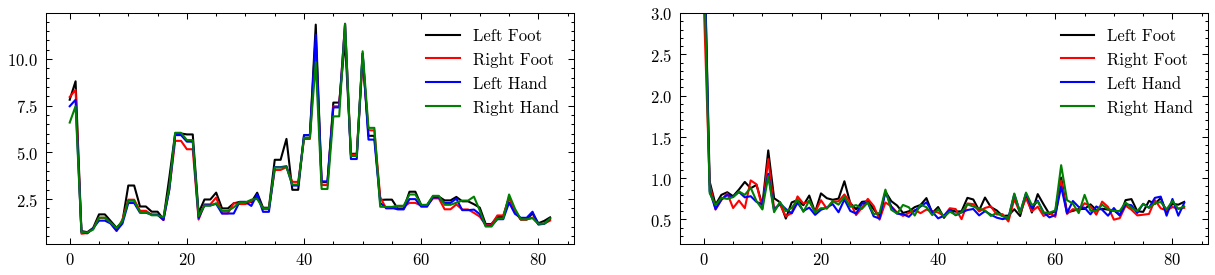

In [8]:
# Comparing spectrum
fig, ax = plt.subplots(1, 2, figsize=(10,2))
ax[0].plot(np.abs(lfoot_gft).mean(axis=0), label='Left Foot', linestyle='solid')
ax[0].plot(np.abs(rfoot_gft).mean(axis=0), label='Right Foot', linestyle='solid')
ax[0].plot(np.abs(lhand_gft).mean(axis=0), label='Left Hand', linestyle='solid')
ax[0].plot(np.abs(rhand_gft).mean(axis=0), label='Right Hand', linestyle='solid')
ax[0].legend()

ax[1].plot(np.abs(lfoot_gft_u).mean(axis=0), label='Left Foot', linestyle='solid')
ax[1].plot(np.abs(rfoot_gft_u).mean(axis=0), label='Right Foot', linestyle='solid')
ax[1].plot(np.abs(lhand_gft_u).mean(axis=0), label='Left Hand', linestyle='solid')
ax[1].plot(np.abs(rhand_gft_u).mean(axis=0), label='Right Hand', linestyle='solid')
ax[1].legend()
ax[1].set_ylim(0.2, 3)

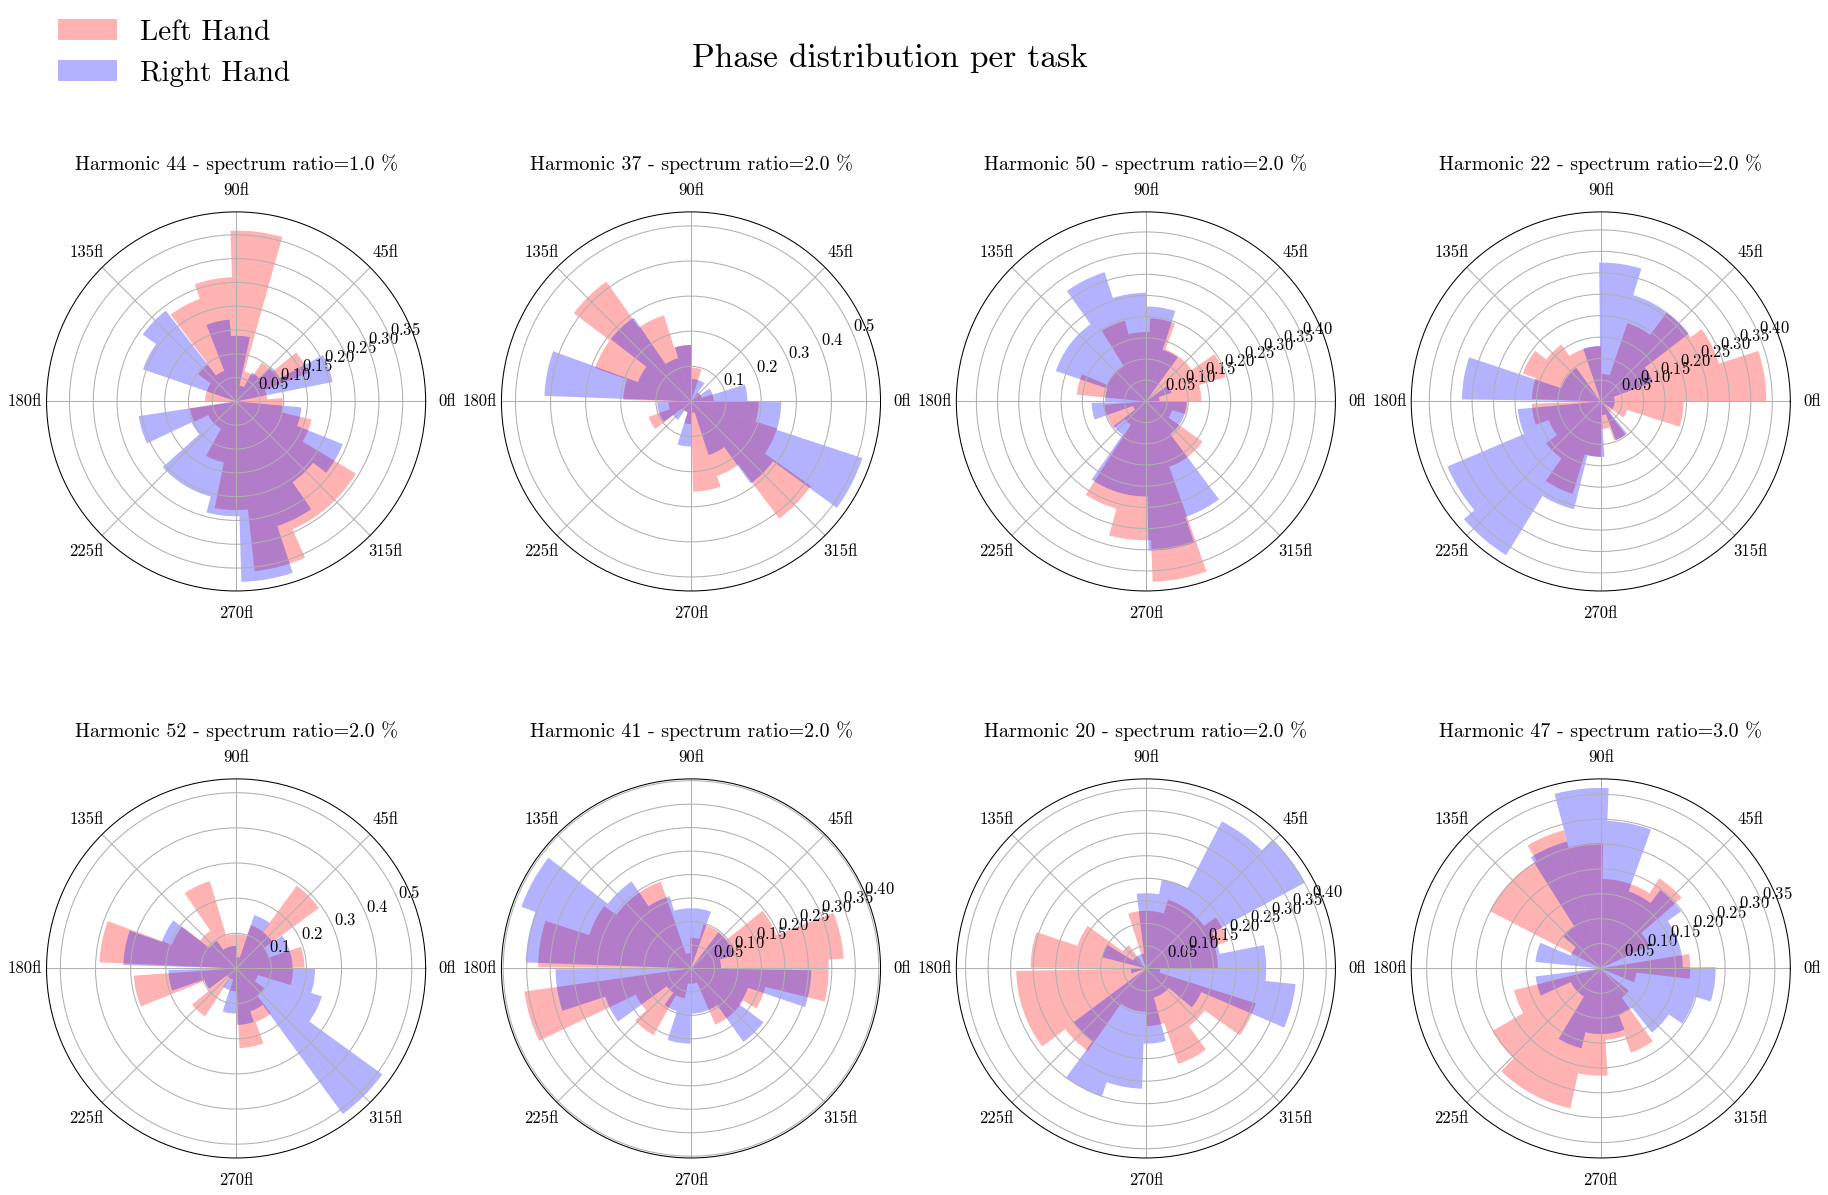

In [9]:
nb_displays = 100

phase_harmonics_amp_hand = np.abs(lhand_gft).mean(axis=0) * (V.imag > 0).astype(float)
indexes_hand = np.argsort(phase_harmonics_amp_hand)[-8:]

fig, ax = plt.subplots(2, 4, subplot_kw={'projection': 'polar'}, figsize=(15, 9))
# colors = plt.cm.viridis(np.linspace(0, 1, nb_displays))

for figidx, idx in enumerate(indexes_hand):
    r,c = figidx // 4, figidx % 4

    left_hand_angles = np.angle(lhand_gft[:nb_displays, idx])
    right_hand_angles = np.angle(rhand_gft[:nb_displays, idx])

    left_foot_angles = np.angle(lfoot_gft[:nb_displays, idx])
    right_foot_angles = np.angle(rfoot_gft[:nb_displays, idx])

    # ax[figidx].plot(angles, amp)
    # ax[figidx].scatter(left_hand_angles, np.ones(len(left_hand_angles)), c='r')
    # ax[figidx].scatter(right_hand_angles, np.ones(len(right_hand_angles)), c='b')
    # ax[figidx].scatter(left_foot_angles, np.ones(len(left_foot_angles)), c='g')
    # ax[figidx].scatter(right_foot_angles, np.ones(len(right_foot_angles)), c='magenta')
    
    ax[r,c].hist(left_hand_angles, bins=20, alpha=0.3, density=True, color='r', label='Left Hand')
    ax[r,c].hist(right_hand_angles, bins=20, alpha=0.3, density=True, color='b', label='Right Hand')

    # sns.kdeplot(left_hand_angles, ax=ax[r,c], color='r', label='Left Foot', fill=True, alpha=0.3)
    # sns.kdeplot(right_hand_angles, ax=ax[r,c], color='b', label='Right Foot', fill=True, alpha=0.3)

    ax[r,c].set_title(f'Harmonic {idx+1} - spectrum ratio={100*np.round(np.abs(lhand_gft).mean(axis=0)[idx]/np.abs(lfoot_gft).mean(axis=0).sum(), 2)} %')

    # ax[figidx].hist(left_foot_angles, bins=30, alpha=0.3, density=True, color='g', label='Left Foot')
    # ax[figidx].hist(right_foot_angles, bins=30, alpha=0.3, density=True, color='magenta', label='Right Foot')

ax[0,0].legend(loc=(0,1.3), fontsize=14)
fig.suptitle('Phase distribution per task', y=.97, size=16)
plt.show()

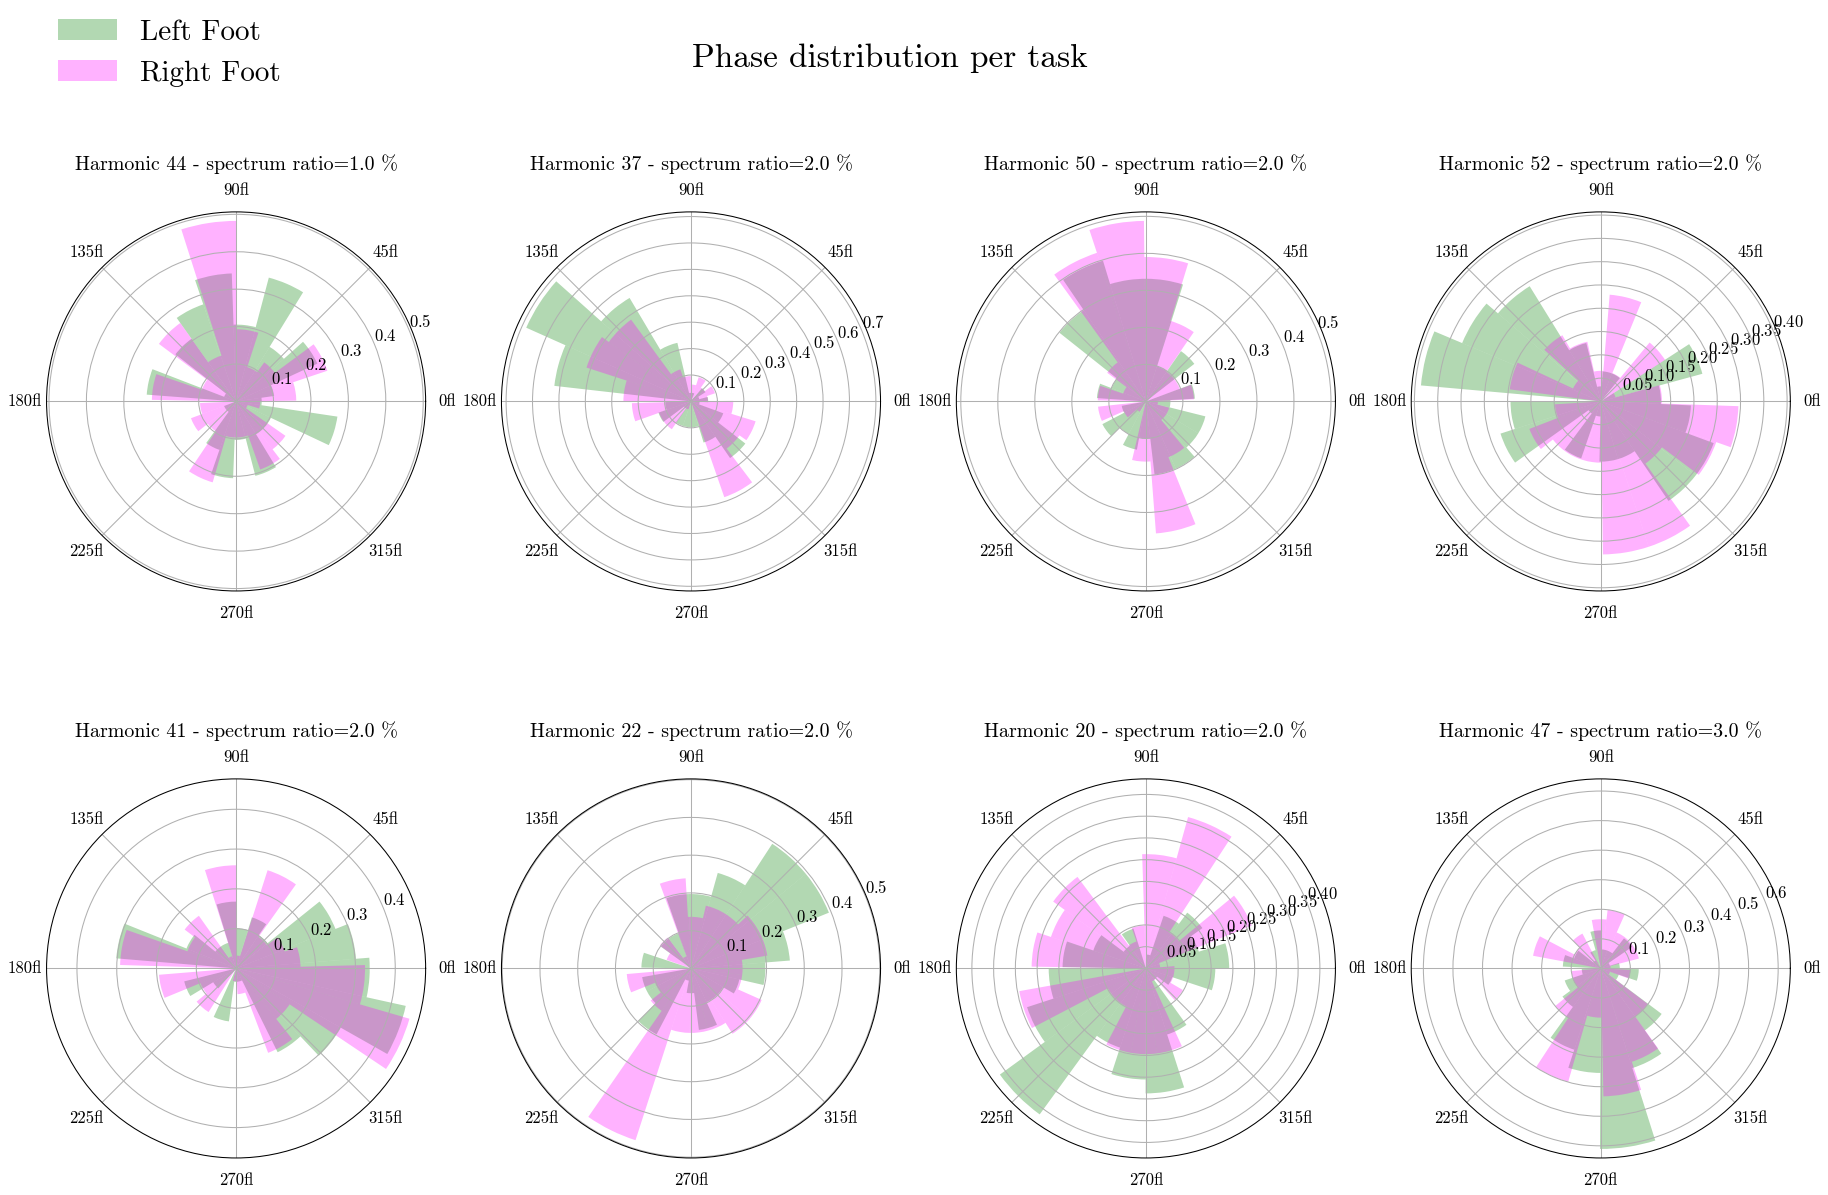

In [10]:
nb_displays = 100

phase_harmonics_amp_foot = np.abs(lfoot_gft).mean(axis=0) * (V.imag > 0).astype(float)
indexes_foot = np.argsort(phase_harmonics_amp_foot)[-8:]

fig, ax = plt.subplots(2, 4, subplot_kw={'projection': 'polar'}, figsize=(15, 9))
# colors = plt.cm.viridis(np.linspace(0, 1, nb_displays))

for figidx, idx in enumerate(indexes_foot):
    r,c = figidx // 4, figidx % 4

    left_hand_angles = np.angle(lhand_gft[:nb_displays, idx])
    right_hand_angles = np.angle(rhand_gft[:nb_displays, idx])

    left_foot_angles = np.angle(lfoot_gft[:nb_displays, idx])
    right_foot_angles = np.angle(rfoot_gft[:nb_displays, idx])

    # ax[figidx].plot(angles, amp)
    # ax[figidx].scatter(left_hand_angles, np.ones(len(left_hand_angles)), c='r')
    # ax[figidx].scatter(right_hand_angles, np.ones(len(right_hand_angles)), c='b')
    # ax[figidx].scatter(left_foot_angles, np.ones(len(left_foot_angles)), c='g')
    # ax[figidx].scatter(right_foot_angles, np.ones(len(right_foot_angles)), c='magenta')
    
    # ax[r,c].hist(left_hand_angles, bins=30, alpha=0.3, density=True, color='r', label='Left Hand')
    # ax[r,c].hist(right_hand_angles, bins=30, alpha=0.3, density=True, color='b', label='Right Hand')

    ax[r,c].set_title(f'Harmonic {idx+1} - spectrum ratio={100*np.round(np.abs(lfoot_gft).mean(axis=0)[idx]/np.abs(lfoot_gft).mean(axis=0).sum(), 2)} %')

    ax[r,c].hist(left_foot_angles, bins=20, alpha=0.3, density=True, color='g', label='Left Foot')
    ax[r,c].hist(right_foot_angles, bins=20, alpha=0.3, density=True, color='magenta', label='Right Foot')

    # sns.kdeplot(left_foot_angles, ax=ax[r,c], color='g', label='Left Foot', fill=True, alpha=0.3)
    # sns.kdeplot(right_foot_angles, ax=ax[r,c], color='magenta', label='Right Foot', fill=True, alpha=0.3)

ax[0,0].legend(loc=(0,1.3), fontsize=14)
fig.suptitle('Phase distribution per task', y=.97, size=16)
plt.show()

#### Individual level harmonic decomposition - tasks specific phase

In [11]:
per_subject_paradigm1 = []
per_subject_paradigm2 = []
for subject in list_subjects:
    per_subject_paradigm1.append(loadmat(op.join(data_path, f'HCP_sample/HCP_taskparadigm_labels/{subject}_Regressor_tfMRI_MOTOR_LR.mat'))['Regressor'][0])
    per_subject_paradigm2.append(loadmat(op.join(data_path, f'HCP_sample/HCP_taskparadigm_labels/{subject}_Regressor_tfMRI_MOTOR_RL.mat'))['Regressor'][0])

per_subject_paradigm1 = np.array(per_subject_paradigm1)
per_subject_paradigm2 = np.array(per_subject_paradigm2)

gft_subjects_timecourse1 = []
gft_subjects_timecourse2 = []

nsubject, nbtime_persubject = per_subject_paradigm1.shape
for sub_idx in range(nsubject):
    gft_subjects_timecourse1.append([operations.GFT(motor1_roi_timecourses[:, t], U=U, Uinv=Uinv) 
                                     for t in range(nbtime_persubject * sub_idx, nbtime_persubject * (sub_idx + 1))])
    
    gft_subjects_timecourse2.append([operations.GFT(motor2_roi_timecourses[:, t], U=U, Uinv=Uinv) 
                                     for t in range(nbtime_persubject * sub_idx, nbtime_persubject * (sub_idx + 1))])

gft_subjects_timecourse1 = np.array(gft_subjects_timecourse1)
gft_subjects_timecourse2 = np.array(gft_subjects_timecourse2)

left_foot_subj_1, left_foot_subj_2 = gft_subjects_timecourse1[:, np.where(taskparadigms1[:nbtime_persubject] == 1)[0], :], gft_subjects_timecourse2[:, np.where(taskparadigms2[:nbtime_persubject] == 1)[0], :]
right_foot_subj_1, right_foot_subj_2 = gft_subjects_timecourse1[:, np.where(taskparadigms1[:nbtime_persubject] == 2)[0], :], gft_subjects_timecourse2[:, np.where(taskparadigms2[:nbtime_persubject] == 2)[0], :]

left_hand_subj_1, left_hand_subj_2 = gft_subjects_timecourse1[:, np.where(taskparadigms1[:nbtime_persubject] == 3)[0], :], gft_subjects_timecourse2[:, np.where(taskparadigms2[:nbtime_persubject] == 3)[0], :]
right_hand_subj_1, right_hand_subj_2 = gft_subjects_timecourse1[:, np.where(taskparadigms1[:nbtime_persubject] == 4)[0], :], gft_subjects_timecourse2[:, np.where(taskparadigms2[:nbtime_persubject] == 4)[0], :]

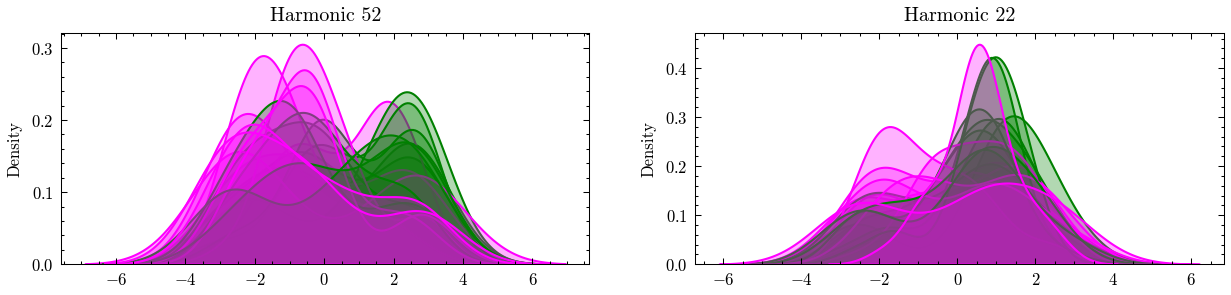

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 2))
harmonic_indexes = [51, 21]
for hidx, harmonic_idx in enumerate(harmonic_indexes):
    for k in range(nsubject):
        sns.kdeplot(np.angle(left_foot_subj_1[k, :, harmonic_idx]), color='g', fill=True, alpha=0.3, ax=ax[hidx])
        sns.kdeplot(np.angle(left_foot_subj_2[k, :, harmonic_idx]), color='g', fill=True, alpha=0.3, ax=ax[hidx])
        sns.kdeplot(np.angle(right_foot_subj_1[k, :, harmonic_idx]), color='magenta', fill=True, alpha=0.3, ax=ax[hidx])
        sns.kdeplot(np.angle(right_foot_subj_2[k, :, harmonic_idx]), color='magenta', fill=True, alpha=0.3, ax=ax[hidx])
    ax[hidx].set_title(f'Harmonic {harmonic_idx+1}')

In [ ]:
from pycircstat2 import Circular
from pycircstat2.hypothesis import watson_u2_test, wheeler_watson_test, watson_williams_test

harmonic_idx = 19
left_footang = np.concatenate([np.angle(left_foot_subj_1[:, :, harmonic_idx]), np.angle(left_foot_subj_2[:, :, harmonic_idx])], axis=1)
right_footang = np.concatenate([np.angle(right_foot_subj_1[:, :, harmonic_idx]), np.angle(right_foot_subj_2[:, :, harmonic_idx])], axis=1)

left_handang = np.concatenate([np.angle(left_hand_subj_1[:, :, harmonic_idx]), np.angle(left_hand_subj_2[:, :, harmonic_idx])], axis=1)
right_handang = np.concatenate([np.angle(right_hand_subj_1[:, :, harmonic_idx]), np.angle(right_hand_subj_2[:, :, harmonic_idx])], axis=1)

betweensubject_foot = np.zeros((nsubject, nsubject))
lateral_foot = np.zeros((nsubject, nsubject))
for nsub in range(nsubject):
    for msub in range(nsubject):
        circ1 = Circular(left_footang[nsub] % (2*np.pi), unit="radian")
        circ2 = Circular(left_footang[msub] % (2*np.pi), unit="radian")
        circ3 = Circular(right_footang[msub] % (2*np.pi), unit="radian")

        stat1, pval1 = wheeler_watson_test([circ1, circ2])
        stat2, pval2 = wheeler_watson_test([circ1, circ3])

        betweensubject_foot[nsub, msub] = pval1
        lateral_foot[nsub, msub] = pval2

fig, ax = plt.subplots(1, 2, figsize=(6, 2))
betweensubject_foot[np.eye(nsubject)==1] = 1 # Set to 1 since p-val is not meaningful when self-comparing
sns.heatmap(betweensubject_foot, annot=True, annot_kws={"size": 6}, ax=ax[0], fmt='.1e')
sns.heatmap(lateral_foot, annot=True, annot_kws={"size": 6}, ax=ax[1], fmt='.1e')
ax[0].set_title('Between subject')
ax[1].set_title('Lateral')

In [ ]:
pvalues_foot = []
pvalues_hand = []
for harmonic_idx in indexes_foot: # same indexes as the ones on hand

    left_footang = np.concatenate([np.angle(left_foot_subj_1[:, :, harmonic_idx]), np.angle(left_foot_subj_2[:, :, harmonic_idx])], axis=1)
    right_footang = np.concatenate([np.angle(right_foot_subj_1[:, :, harmonic_idx]), np.angle(right_foot_subj_2[:, :, harmonic_idx])], axis=1)

    left_handang = np.concatenate([np.angle(left_hand_subj_1[:, :, harmonic_idx]), np.angle(left_hand_subj_2[:, :, harmonic_idx])], axis=1)
    right_handang = np.concatenate([np.angle(right_hand_subj_1[:, :, harmonic_idx]), np.angle(right_hand_subj_2[:, :, harmonic_idx])], axis=1)

    group_circs_left_foot = [Circular(left_footang[nsub] % (2*np.pi), unit="radian") for nsub in range(nsubject)]
    group_circs_right_foot = [Circular(right_footang[nsub] % (2*np.pi), unit="radian") for nsub in range(nsubject)]
    group_circs_left_hand = [Circular(left_handang[nsub] % (2*np.pi), unit="radian") for nsub in range(nsubject)]
    group_circs_right_hand = [Circular(right_handang[nsub] % (2*np.pi), unit="radian") for nsub in range(nsubject)]

    all_circs_foot = [Circular(np.concatenate(left_footang) % (2*np.pi), unit="radian"), 
                    Circular(np.concatenate(right_footang) % (2*np.pi), unit="radian")]
    all_circs_hand = [Circular(np.concatenate(left_handang) % (2*np.pi), unit="radian"), 
                    Circular(np.concatenate(right_handang) % (2*np.pi), unit="radian")]

    _, pval_group_left_foot = wheeler_watson_test(group_circs_left_foot)
    _, pval_group_right_foot = wheeler_watson_test(group_circs_right_foot)
    _, pval_group_all_foot = wheeler_watson_test(all_circs_foot)

    _, pval_group_left_hand = wheeler_watson_test(group_circs_left_hand)
    _, pval_group_right_hand = wheeler_watson_test(group_circs_right_hand)
    _, pval_group_all_hand = wheeler_watson_test(all_circs_hand)

    # _, pval_group_left_foot = watson_williams_test(group_circs_left_foot)
    # _, pval_group_right_foot = watson_williams_test(group_circs_right_foot)
    # _, pval_group_all_foot = watson_williams_test(all_circs_foot)

    # _, pval_group_left_hand = watson_williams_test(group_circs_left_hand)
    # _, pval_group_right_hand = watson_williams_test(group_circs_right_hand)
    # _, pval_group_all_hand = watson_williams_test(all_circs_hand)

    pvalues_foot.append([pval_group_left_foot, pval_group_right_foot, pval_group_all_foot])
    pvalues_hand.append([pval_group_left_hand, pval_group_right_hand, pval_group_all_hand])

pvalues_foot = np.array(pvalues_foot)
pvalues_hand = np.array(pvalues_hand)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

# Plot for pvalues_foot
bar_width = 0.25
index = np.arange(len(indexes_foot))

bar1 = ax1.bar(index, 1-pvalues_foot[:, 0], bar_width, label='Left Foot between subjects')
bar2 = ax1.bar(index + bar_width, 1-pvalues_foot[:, 1], bar_width, label='Right Foot between subjects')
bar3 = ax1.bar(index + 2 * bar_width, 1-pvalues_foot[:, 2], bar_width, label='Lateralized Foot')

ax1.set_xlabel('Harmonic Index', fontsize=14)
ax1.set_ylabel('Confidence level', fontsize=14)
ax1.set_title('Confidence level for Foot Harmonics', fontsize=16)
ax1.set_xticks(index + bar_width)
ax1.set_xticklabels(indexes_foot, fontsize=12)
ax1.legend(fontsize=12)
ax1.set_ylim(0.5, 1.28)

alpha_level = 0.05 / (8 * 3)
# Add stars for statistical significance
for i in range(len(indexes_foot)):
    if 1 - pvalues_foot[i, 0] > (1- alpha_level):
        ax1.text(i, 1 - pvalues_foot[i, 0] + 0.01, '*', ha='center', va='bottom', fontsize=20)
    if 1 - pvalues_foot[i, 1] > (1- alpha_level):
        ax1.text(i + bar_width, 1 - pvalues_foot[i, 1] + 0.01, '*', ha='center', va='bottom', fontsize=20)
    if 1 - pvalues_foot[i, 2] > (1- alpha_level):
        ax1.text(i + 2 * bar_width, 1 - pvalues_foot[i, 2] + 0.01, '*', ha='center', va='bottom', fontsize=20)

# Plot for pvalues_hand
bar1 = ax2.bar(index, 1-pvalues_hand[:, 0], bar_width, label='Left Hand between subjects')
bar2 = ax2.bar(index + bar_width, 1-pvalues_hand[:, 1], bar_width, label='Right Hand between subjects')
bar3 = ax2.bar(index + 2 * bar_width, 1-pvalues_hand[:, 2], bar_width, label='Lateralized Hand')

ax2.set_xlabel('Harmonic Index', fontsize=14)
ax2.set_ylabel('Confidence level', fontsize=14)
ax2.set_title('Confidence level for Hand Harmonics', fontsize=16)
ax2.set_xticks(index + bar_width)
ax2.set_xticklabels(indexes_foot, fontsize=12)
ax2.legend(fontsize=12)

# Add stars for statistical significance
for i in range(len(indexes_foot)):
    if 1 - pvalues_hand[i, 0] > (1- alpha_level):
        ax2.text(i, 1 - pvalues_hand[i, 0] + 0.01, '*', ha='center', va='bottom', fontsize=20)
    if 1 - pvalues_hand[i, 1] > (1- alpha_level):
        ax2.text(i + bar_width, 1 - pvalues_hand[i, 1] + 0.01, '*', ha='center', va='bottom', fontsize=20)
    if 1 - pvalues_hand[i, 2] > (1- alpha_level):
        ax2.text(i + 2 * bar_width, 1 - pvalues_hand[i, 2] + 0.01, '*', ha='center', va='bottom', fontsize=20)
ax2.set_ylim(0.5, 1.28)

plt.tight_layout()
plt.show()

### Look at significant harmonics

In [19]:
avg_lefthand_gft = np.mean(np.concatenate([left_hand_subj_1, left_hand_subj_2], axis=1), axis=(0,1))
avg_righthand_gft = np.mean(np.concatenate([right_hand_subj_1, right_hand_subj_2], axis=1), axis=(0,1))

avg_leftfoot_gft = np.mean(np.concatenate([left_foot_subj_1, left_foot_subj_2], axis=1), axis=(0,1))
avg_rightfoot_gft = np.mean(np.concatenate([right_foot_subj_1, right_foot_subj_2], axis=1), axis=(0,1))

(<Figure size 450x450 with 8 Axes>, <Axes3D: title={'center': 'Left'}>)

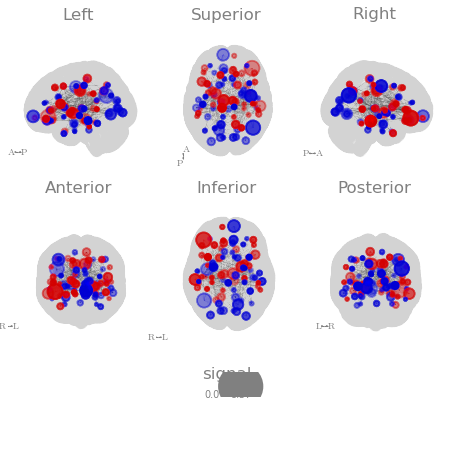

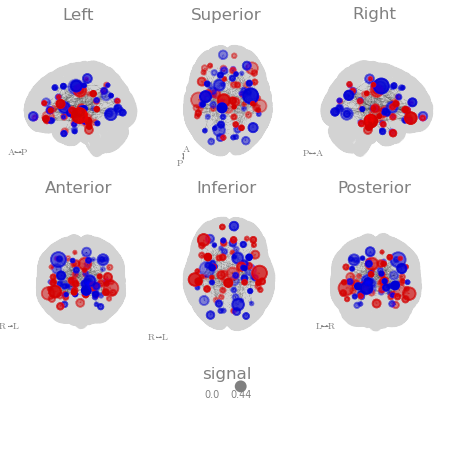

In [20]:
importlib.reload(braingraph_utils)
# netplotbrain uses PYTHON3.8 -> switch to dGSP environment
h1, h2 = 19, 21
braingraph_utils.visualize_braingraph((U[:, h1] * avg_lefthand_gft[h1]).real, A, regioncoords, 
                     figsize=(3, 3), nscale=50)

braingraph_utils.visualize_braingraph((U[:, h1] * avg_righthand_gft[h1]).real, A, regioncoords, 
                     figsize=(3, 3), nscale=50)

In [39]:
motor_rois = ['inferiorparietal', 'postcentral', 'precuneus', 'superiorparietal', 'supramarginal', 'paracentral', 'precentral',
              'parsopercularis','paracentral','rostralmiddlefrontal', 'pallidum', 'putamen', 'stem']
hand_rois = ['parsopercularis']
foot_rois = ['paracentral']

motor_indexes = [i for i, label in enumerate(region_labels) if any(motor_roi in label.lower() for motor_roi in motor_rois)]
hand_indexes = [i for i, label in enumerate(region_labels) if any(hand_roi in label.lower() for hand_roi in hand_rois)]
foot_indexes = [i for i, label in enumerate(region_labels) if any(foot_roi in label.lower() for foot_roi in foot_rois)]

(<Figure size 450x450 with 8 Axes>, <Axes3D: title={'center': 'Left'}>)

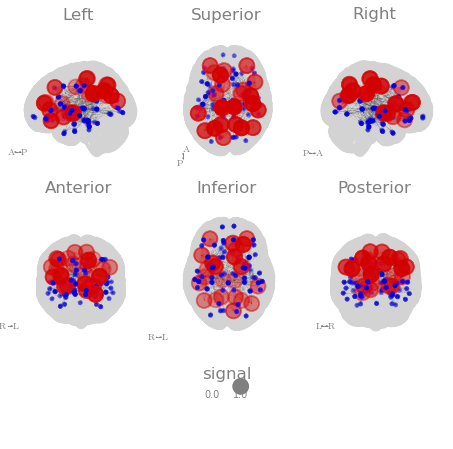

In [ ]:
indicator = np.zeros(nb_nodes) ; indicator[np.array(motor_indexes)] = -1
braingraph_utils.visualize_braingraph(indicator, A, regioncoords, 
                     figsize=(3, 3), nscale=20)

(<Figure size 450x450 with 8 Axes>, <Axes3D: title={'center': 'Left'}>)

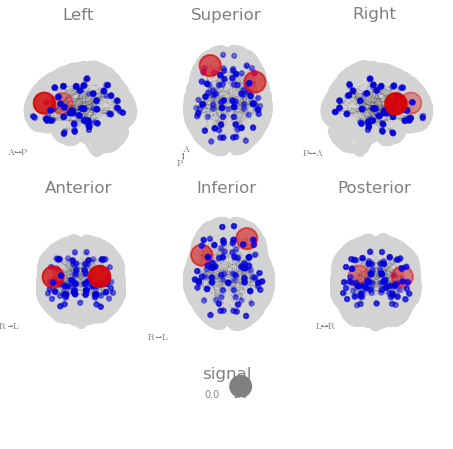

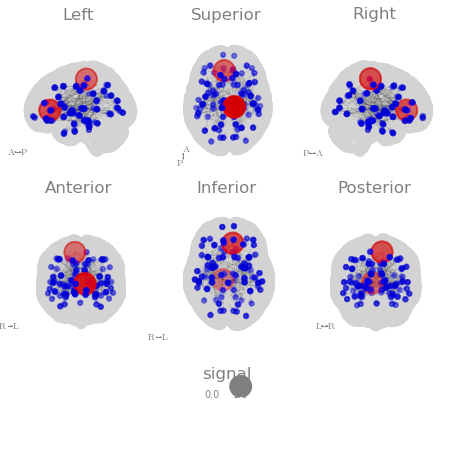

In [48]:
indicator_hand = np.zeros(nb_nodes) ; indicator_hand[np.array(hand_indexes)] = -1
braingraph_utils.visualize_braingraph(indicator_hand, A, regioncoords, 
                     figsize=(3, 3), nscale=100)
indicator_foot = np.zeros(nb_nodes) ; indicator_foot[np.array(foot_indexes)] = -1
braingraph_utils.visualize_braingraph(indicator_foot, A, regioncoords, 
                     figsize=(3, 3), nscale=100)

Masking the oscillation with regions of interest

(<Figure size 450x450 with 8 Axes>, <Axes3D: title={'center': 'Left'}>)

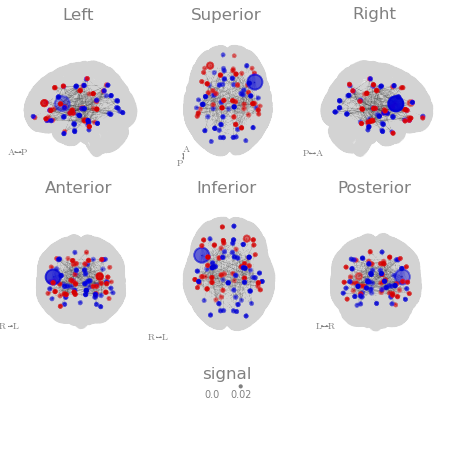

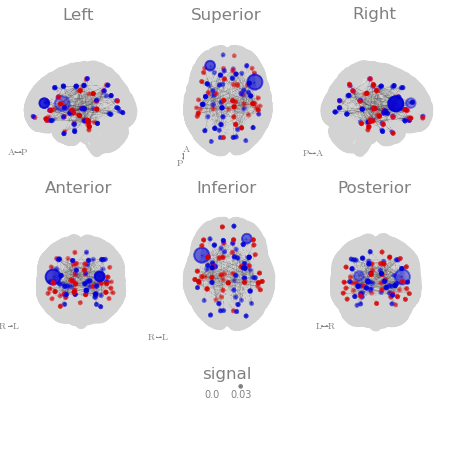

In [50]:
braingraph_utils.visualize_braingraph((U[:, h1] * avg_lefthand_gft[h1]).real * indicator_hand, A, regioncoords, 
                     figsize=(3, 3), nscale=50)

braingraph_utils.visualize_braingraph((U[:, h1] * avg_righthand_gft[h1]).real * indicator_hand, A, regioncoords, 
                     figsize=(3, 3), nscale=50)

(<Figure size 450x450 with 8 Axes>, <Axes3D: title={'center': 'Left'}>)

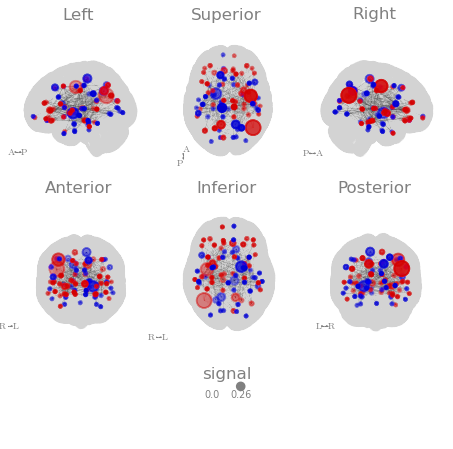

In [51]:
braingraph_utils.visualize_braingraph((U[:, h1] * avg_lefthand_gft[h1]).real * indicator, A, regioncoords, 
                     figsize=(3, 3), nscale=50)

Generate a dynamic plot of phase shifted harmonic to see axis of oscillation

In [22]:
import cv2
importlib.reload(braingraph_utils)
phases_shifted = np.array([operations.apply_phaseshift(ps, U[:, h2].real, U, V, Uinv=Uinv) 
                           for ps in np.linspace(0, 2*np.pi, 100)])
braingraph_utils.visualize_braingraph_dynamic(phases_shifted.real, A, regioncoords, figsize=(5, 5))

f'./figure_resources/braingraph_{k}.png'
image_folder = '../figure_resources/'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
video_name = op.join(image_folder, 'tmp.mp4')
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), 10, (width, height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

!ffmpeg -i ../figure_resources/tmp.mp4 ../figure_resources/lateralized_hand-foot-harmonic_21.mp4 -y

ffmpeg version 7.0 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.0 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopenvino --enable-libspeex